In [7]:
# ✅ Import libraries
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import neurokit2 as nk
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler 

In [8]:


# ✅ Path to database
db_name = "C:/Users/arfao/Desktop/stage_2025/european-st-t-database-1.0.0"

# ✅ Create output directory
output_dir = "C:/Users/arfao/Desktop/stage_2025/european-st-t-database-1.0.0/processed"
os.makedirs(output_dir, exist_ok=True)

# ✅ List of records
records = [f.split('.')[0] for f in os.listdir(db_name) if f.endswith('.hea')]
all_symbols = []
for rec in records:
    annotation = wfdb.rdann(os.path.join(db_name, rec), 'atr')
    all_symbols.extend(annotation.symbol)

print(f"Unique annotation symbols: {set(all_symbols)}")

# ✅ Bandpass filter function
def bandpass_filter(signal, lowcut=0.5, highcut=50.0, fs=250, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# ✅ Normalize signal
def normalize_signal(signal):
    return (signal - np.mean(signal)) / (np.max(np.abs(signal)) + 1e-10)

# ✅ Segment signal around annotations
def segment_beats(signal, annotations, window_size=250):
    segments = []
    labels = []
    for i, ann in enumerate(annotations.symbol):
        beat_pos = annotations.sample[i]
        if beat_pos - window_size//2 >= 0 and beat_pos + window_size//2 < len(signal):
            segment = signal[beat_pos - window_size//2 : beat_pos + window_size//2]
            label = 1 if ann in ['N'] else 0  # Normal = 1, abnormal = 0
            segments.append(segment)
            labels.append(label)
    return np.array(segments), np.array(labels)

# ✅ Process records
all_segments = []
all_labels = []
for rec in records:
    record = wfdb.rdrecord(os.path.join(db_name, rec))
    annotation = wfdb.rdann(os.path.join(db_name, rec), 'atr')
    
    ecg_signal = record.p_signal[:, 0]
    filtered = bandpass_filter(ecg_signal, fs=record.fs)
    normalized = normalize_signal(filtered)
    
    segments, labels = segment_beats(normalized, annotation)
    all_segments.append(segments)
    all_labels.append(labels)

# ✅ Concatenate all
X = np.concatenate(all_segments, axis=0)
y = np.concatenate(all_labels, axis=0)

# ✅ Save segments
np.save(os.path.join(output_dir, 'X_segments.npy'), X)
np.save(os.path.join(output_dir, 'y_labels.npy'), y)

print(f"Saved {X.shape[0]} segments. {np.sum(y)} normal, {X.shape[0] - np.sum(y)} abnormal.")


Unique annotation symbols: {'V', 'S', '+', '|', '~', 'F', 's', 'T', 'a', '"', 'J', 'n', 'Q', 'N'}
Saved 802735 segments. 784535 normal, 18200 abnormal.


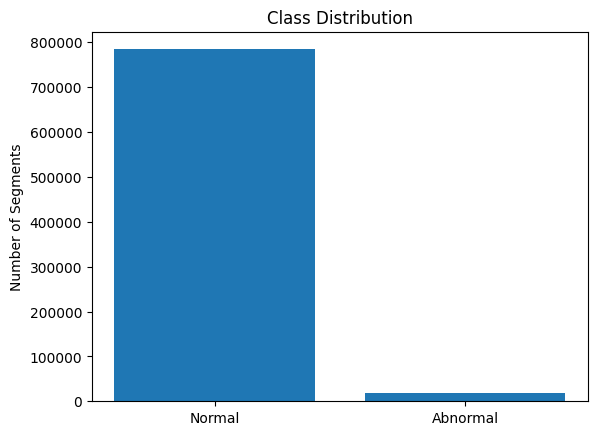

In [9]:
import matplotlib.pyplot as plt

plt.bar(['Normal', 'Abnormal'], [np.sum(y), len(y) - np.sum(y)])
plt.title("Class Distribution")
plt.ylabel("Number of Segments")
plt.show()


Original class distribution: Counter({0: 784535, 1: 4467, 5: 2466, 2: 1093})
SMOTE target per class: {1: 35740, 2: 35740, 5: 35740}
Class distribution after SMOTE: Counter({0: 627627, 1: 35740, 2: 35740, 5: 35740})
Final balanced class distribution: Counter({0: 35740, 1: 35740, 2: 35740, 5: 35740})


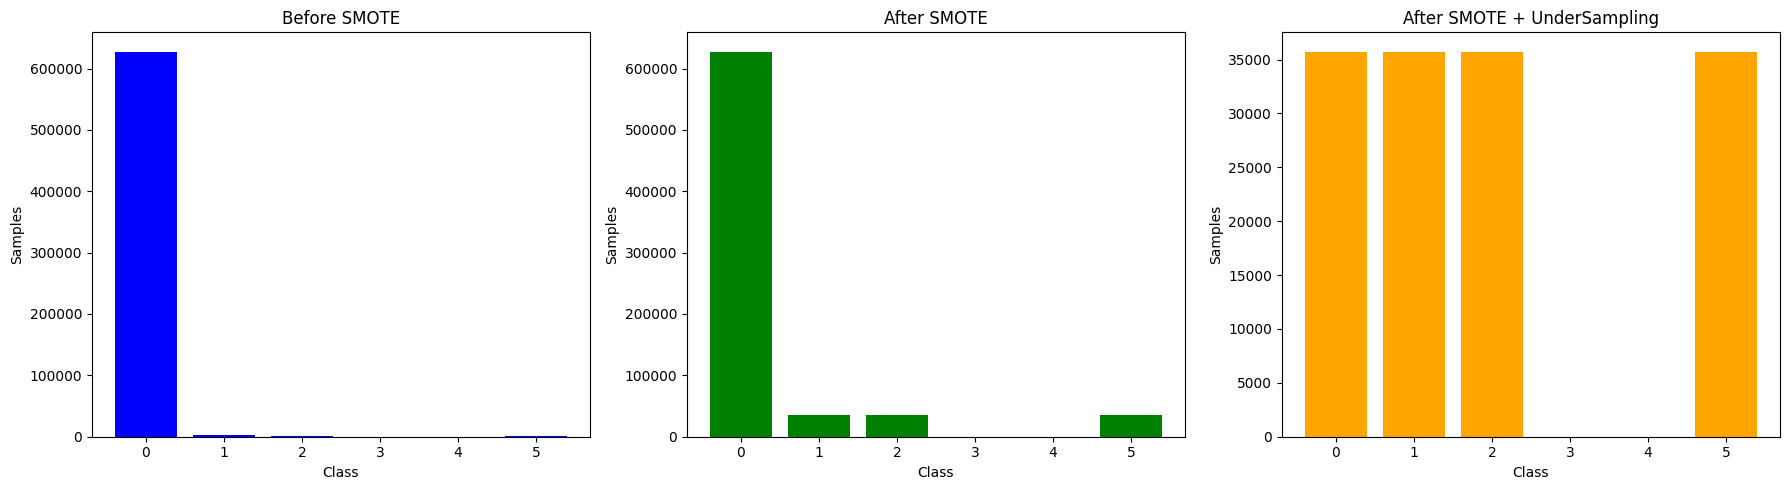

Test classes after alignment: [0 1 2 5]
Balanced test class distribution: Counter({0: 219, 1: 219, 2: 219, 5: 219})


c:\Users\arfao\Desktop\stage_2025\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:35:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (Balanced Test Set):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       219
           1       0.97      0.95      0.96       219
           2       0.97      0.83      0.89       219
           5       0.97      0.95      0.96       219

    accuracy                           0.93       876
   macro avg       0.94      0.93      0.93       876
weighted avg       0.94      0.93      0.93       876



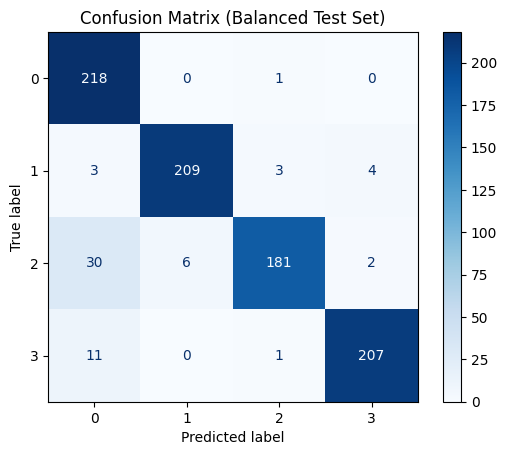

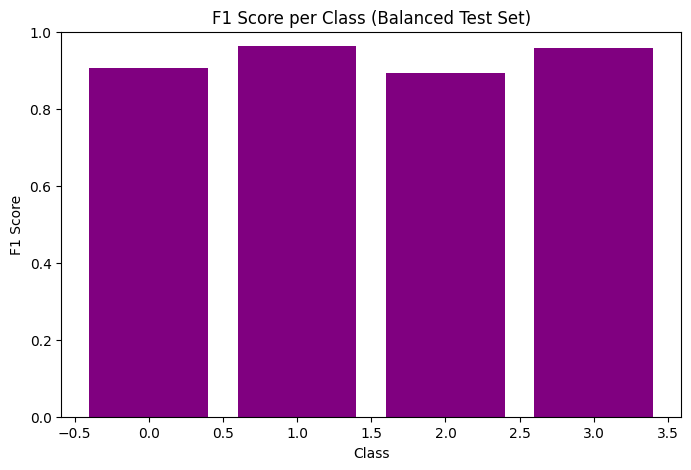

In [5]:
# ✅ Import libraries
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# ✅ Load segmented data
X = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/X_segments.npy")
y = np.load("C:/Users/arfao/Desktop/stage_2025/processed_multiclass_filtered500/y_labels.npy")

print(f"Original class distribution: {Counter(y)}")

# ✅ Flatten and scale
X_flat = X.reshape((X.shape[0], -1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# ✅ Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# ✅ SMOTE + undersample
minority_classes = [cls for cls in Counter(y_train) if cls != Counter(y_train).most_common(1)[0][0]]
largest_minority_count = max([Counter(y_train)[cls] for cls in minority_classes])
target_count = largest_minority_count * 10

smote_strategy = {cls: target_count for cls in Counter(y_train) if cls != Counter(y_train).most_common(1)[0][0]}
print(f"SMOTE target per class: {smote_strategy}")

sm = SMOTE(random_state=42, sampling_strategy=smote_strategy)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Class distribution after SMOTE: {Counter(y_train_res)}")

majority_class = Counter(y_train).most_common(1)[0][0]
rus_strategy = {cls: target_count for cls in Counter(y_train_res)}
rus = RandomUnderSampler(sampling_strategy=rus_strategy, random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train_res, y_train_res)

print(f"Final balanced class distribution: {Counter(y_train_bal)}")

# ✅ Plot distributions
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].bar(Counter(y_train).keys(), Counter(y_train).values(), color='blue')
ax[0].set_title('Before SMOTE')
ax[1].bar(Counter(y_train_res).keys(), Counter(y_train_res).values(), color='green')
ax[1].set_title('After SMOTE')
ax[2].bar(Counter(y_train_bal).keys(), Counter(y_train_bal).values(), color='orange')
ax[2].set_title('After SMOTE + UnderSampling')
for a in ax:
    a.set_xlabel('Class')
    a.set_ylabel('Samples')
plt.tight_layout()
plt.show()

# ✅ Align test set to train classes
train_classes = np.unique(y_train_bal)
mask = np.isin(y_test, train_classes)
X_test = X_test[mask]
y_test = y_test[mask]
print(f"Test classes after alignment: {np.unique(y_test)}")

# ✅ Balance test set
min_test_count = min(Counter(y_test).values())
test_sampling_strategy = {cls: min_test_count for cls in np.unique(y_test)}

rus_test = RandomUnderSampler(sampling_strategy=test_sampling_strategy, random_state=42)
X_test_bal, y_test_bal = rus_test.fit_resample(X_test, y_test)

print(f"Balanced test class distribution: {Counter(y_test_bal)}")

# ✅ Label encode
le = LabelEncoder()
y_train_bal = le.fit_transform(y_train_bal)
y_test_bal = le.transform(y_test_bal)

# ✅ Train XGBoost
clf = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
clf.fit(X_train_bal, y_train_bal)

# ✅ Predict + evaluate
y_pred_bal = clf.predict(X_test_bal)

# Decode for report
y_pred_bal_orig = le.inverse_transform(y_pred_bal)
y_test_bal_orig = le.inverse_transform(y_test_bal)

print("Classification Report (Balanced Test Set):")
print(classification_report(y_test_bal_orig, y_pred_bal_orig))

cm = confusion_matrix(y_test_bal, y_pred_bal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Balanced Test Set)")
plt.show()

f1_per_class = f1_score(y_test_bal, y_pred_bal, average=None)
classes = sorted(list(set(y_test_bal)))

plt.figure(figsize=(8, 5))
plt.bar(classes, f1_per_class, color='purple')
plt.title('F1 Score per Class (Balanced Test Set)')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()
